# Choose a Car Profitably [Car Price prediction] PART.2

In this part we will focus on feature engineering and building a several models

This work has made by Paul Krivchenia in cooperation with Vitaliy Burlakov (a.k.a Vetak8):
#### [My GitHub](https://github.com/Paull-dark)
#### [Vetak's GitHub](https://github.com/vetak8)
#### [Vetak's Kaggle](https://www.kaggle.com/vitaliyburlakov)

<img src = 'http://3.bp.blogspot.com/--knDCWYzMOw/UqzpwyctJeI/AAAAAAAAAT8/Ui66KNd1nXM/s1600/7egylh57hbhs.jpg' width= '400px'>

<a id="sec2"></a>
# [INDEX](#sec2)

<a id="sec1"></a>
1. [Description](#sec1)
   * [1.1 Features Defination](#sec1.1)
2. [INDEX](#sec2)
3. [IMPORT LIBRARRIES](#sec3)
4. [Functions and Classes](#sec4)
5. [Load and Chek the Dataset](#sec5)

<a id="sec2"></a>
# [Import LIBRARIES](#sec2)

In [85]:
from Preprocessing import df_combined

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import ast
import warnings
from jupyterthemes import jtplot

from textblob import TextBlob  # for sentiment analysis
from wordcloud import WordCloud, STOPWORDS  # for creating cloud of words
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import f_regression
from sklearn.model_selection import StratifiedShuffleSplit


#from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRFRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm  as lgb
import lightgbm
import optuna


from xgboost import plot_importance

warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_rows', 50)  # Show more rows
pd.set_option('display.max_columns', 50)  # Show more columns
plt.style.use('ggplot')  # Nice plotting

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

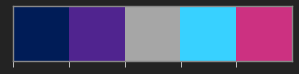

In [2]:
# Set project colors
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

<a id="sec4"></a>
# [FUNCTIONS and CLASSES](#sec4)
[(INDEX)](#sec2)

<a id="sec4"></a>
## [GENERAL FUNCTIONS](#sec4)
[(INDEX)](#sec2)

In [3]:
def missing_vars(data, column, random_proba=True):
    '''Function is called for filling of missing data'''
    # With using probability and random choise

    if random_proba:
        col_name = data[column].value_counts().index.to_list(
        )  # get list of values
        col_distr = data[column].value_counts(
            normalize=True).values  # get l;ist of probs
        missing = data[col].isnull()  # flag of missing val
        # substitute values from the list of names in accordance with the probability of meeting the name
        data.loc[missing, [column]] = np.random.choice(col_name,
                                                    size=len(data[missing]),
                                                    p=col_distr)

    # Using  most common in  column
    data[col] = data[col].fillna(data[col].value_counts().index[0])

In [4]:
def get_variable_distribution(col, title=None):
    '''Function is called to plot feture distribution'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=True, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2)
#     sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)
    sns.boxplot(col.values,color=colors[3])

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Boxplot')

    plt.show()

In [5]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''

    corr = data.corr()
    if det:

        evals, evec = np.linalg.eig(corr)
        ev_product = np.prod(evals)

        print(f'Rank of Matrix: {np.linalg.matrix_rank(corr)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(corr)}')

    plt.figure(figsize=(pltx, plty))
    sns.heatmap(corr[(corr >= .2) | (corr <= -.2)],
                cmap='viridis',
                vmin=-1.0,
                linewidths=0.1,
                annot=True,
                annot_kws={"size": 10},
                square=True)
    #     sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [6]:
def cleanTxt(text):
    '''Function is called for cleaning text from trash
    INPUT: dirty string
    OUTPUT: More or less clean string'''

    text = re.sub(r'@[А-Яа-я0-9]+', '', text)  # Remove @
    text = re.sub(r'#', '', text)  # remove #
    text = re.sub(r'{', '', text)
    text = re.sub(r'}', '', text)
    text = re.sub('^а-яА-Я', ' ', text)
    text = re.sub(r'https?:\/\/\S+', '', text)  # remove hyperlink
    text = re.sub(r'\n', '', text)
    text = re.sub(r'✅', '', text)
    text = re.sub(r'👍🏻', '', text)
    text = re.sub(r'✨', '', text)
    
    
    # there are much more emoji. I don't know how to identify them so far

    text = text.strip()
    text = text.lower()
    #text = text.split()
    return text

In [7]:
def to_log(df, cols_to_log):
    'smart log'
    for col in cols_to_log:
        a = df[col].min()
        if a <= 0:                        
            df[col] = np.log(df[col] + (int(abs(df[col].min()))+2))
        
        df[col] = np.log(df[col])
    return df

In [8]:
# Defining MAPE function since it was removed from sklearn
def mape(y_true, y_pred):
    'Function to calculate MAPE metric'
#     y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [9]:
def get_regression_metrics(report_df,y_true, y_pred, name):
    '''Create and add metrics into a pandas DF after experiment'''
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)

    report = pd.DataFrame(columns={'MAPE'}, data=[0])
    try:
        report['MAPE'] = mape(y_true, y_pred)
    except:
        report['MAPE'] = 'failed'
    report['MAE'] = mean_absolute_error(y_true, y_pred)
    report['MSE'] = mean_squared_error(y_true, y_pred)
    report['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

<a id="sec4"></a>
## [Classes](#sec4)
[(INDEX)](#sec2)

In [10]:
class Encoder():
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def label_encoder(self, column):
        '''Method is called for label encoding'''
        le = LabelEncoder()
        self.dataframe[column] = le.fit_transform(self.dataframe[column])

    def hot_encoder(self, column):
        '''Method is calling for hot encoding'''
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.dataframe[[column]]))
        aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
        self.dataframe = self.dataframe.drop(col, axis=1)
        self.dataframe = pd.concat([self.dataframe, aux_df], axis=1)
        return self.dataframe

In [11]:
class Outliers_detector():
    def __init__(self, df):
        self.df = df

    def get_IQR_outliers(self, column):
        '''Method is called to detect IQR outliers'''
        outliers = dict()
        q1, q3 = np.percentile(sorted(self.df[column]), [25, 75])

        IQR = q3 - q1

        l_b = q1 - (1.5 * IQR)  # lower bound
        u_b = q3 + (1.5 * IQR)  # upper bound
        outl_count = len(self.df[column][self.df[column] < l_b]) + len(
            self.df[column][self.df[column] > u_b])

        outliers['lower_bound'] = round(l_b, 3)
        outliers['upper_bound'] = round(u_b, 3)
        outliers['outlier_count'] = outl_count

        return outliers

    def get_dbscan_outliers(self, column1, column2, dbscan_eps,
                            dbscan_minsample, cluster_num):
        '''Method is called for detecting outliers for two columns by dbscan'''

        scaler = RobustScaler()
        scale_column1 = scaler.fit_transform(pd.DataFrame(
            self.df[column1])).reshape(1, -1)[0]
        scale_column2 = scaler.fit_transform(pd.DataFrame(
            self.df[column2])).reshape(1, -1)[0]
        df_temp = pd.DataFrame({
            'column1': scale_column1,
            'column2': scale_column2
        })
        clustering = DBSCAN(eps=dbscan_eps,
                            min_samples=dbscan_minsample).fit(df_temp.values)
        df_temp["cluster"] = clustering.labels_
        df_temp.index = self.df.index
        fig = px.scatter(self.df,
                   x=scale_column1,
                   y=scale_column2,
                   color=clustering.labels_,
                   size=column2)
        # Edit the layout
        fig.update_layout(title='Detected Custers\n')
        fig.update_xaxes(title=(f'{column1}'))
        fig.update_yaxes(title=(f'{column2}'))
        fig.update_layout(width = 700)
        fig.update_layout(height = 600)
        
        fig.show()
        #         sns.scatterplot(scale_column1, scale_column2,
        #                         hue=clustering.labels_, alpha=0.5)
        #         plt.title('CLUSTERS\n', fontsize=15)
        #         plt.xlabel(f'{column1}')
        #         plt.ylabel(f'{column2}')
        return df_temp[df_temp["cluster"] == cluster_num].index

<a id="sec4"></a>
## [FUNCTIONS FOR FEATURE ENGINEERING](#sec4)
[(INDEX)](#sec2)

In [12]:
def get_tax_category(engine_power):
    '''Function breaks down the number of horse
    power by taxation category in Russia'''

    if engine_power <= 100:
        return int(1)
    elif 100 < engine_power <= 150:
        return int(2)
    elif 150 < engine_power <= 200:
        return int(3)
    elif 200 < engine_power <= 250:
        return int(4)
    elif engine_power > 250:
        return int(5)


def get_low_registr(word):
    '''Get lowercase for string'''
    try:
        return word.lower()
    except:
        return None
    
def get_i3_displacement(engine_displacement, fuel_type, model_name):
    '''fill mising values for  BMW i3'''
    
    if model_name == 'i3':
        if fuel_type == 'hybrid':
            return 0.7
        else:
            return 0
    else:
        return engine_displacement

def get_electro_displacement(engine_displacement, fuel_type):
    '''Filling mising vars for electrocars'''
    
    if fuel_type == 'electro':
        return 0
    else:
        return engine_displacement
    
def get_acceleration(string):
    '''Function extracting acceleration'''
    
    try:
        return float(re.split(',', re.split('acceleration\W+', str(string))[1])[0])
    except:
        return None
    
def get_fuel_rate(string):
    '''Extrating fuel rate'''
    try:
        return float(re.split(',', re.split('fuel_rate\W+', str(string))[1])[0])

    except:
        return None

<a id="sec5"></a>
# [5.Load and Chek the Dataset](#sec5)
[(INDEX)](#sec2)

In [13]:
# import data pre-processed data set
df = df_combined.copy()
df.sample(2)

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,image,mileage,model_date,model_info,model_name,name,doors_count,price_currency,production_date,sell_id,super_gen,vehicle_configuration,vehicle_transmission,vendor,owner_count,owning_period,car_passport,wheel_drive,wheel_location,condition,custom,price,sample
79309,седан,MERCEDES,коричневый,"{'id': '20884178', 'name': 'C 200 4MATIC Sport...",💸Выгода до 100 000 рублей при покупке в кредит...,2.0,184.0,"{'esp': True, 'usb': True, 'sport-seats': True...",бензин,//avatars.mds.yandex.net/get-autoru-vos/433371...,65020,2014,"{'code': 'C_KLASSE', 'name': 'C-Класс', 'ru_na...",C_KLASSE,200 2.0 AT (184 л.с.) 4WD,4,RUB,2015,1103399499,"{'id': '20541497', 'name': '200', 'nameplate':...",useless_col,AUTOMATIC,EUROPEAN,1,NaN,ORIGINAL,полный,LEFT,True,True,1857000.0,1
19872,минивэн,TOYOTA,серебристый,NaN,"Машина в хорошем состоянии. Категория""В"". Оста...",2.0,110.0,NaN,бензин,https://autoru.naydex.net/LxPU17803/f5b8d77S/u...,300000,1989,"{""code"":""HIACE"",""name"":""HiAce"",""ru_name"":""Хайс...",HIACE,2.0 MT (110 л.с.),4,RUB,1998,1093833760,"{""id"":""20500100"",""displacement"":1995,""engine_t...",MINIVAN MECHANICAL 2.0,MECHANICAL,JAPANESE,3,NaN,ORIGINAL,задний,LEFT,Не требует ремонта,Растаможен,NaN,0


<a id="sec6"></a>
# [9.FETAURE ENGINEERING](#sec6)
[(INDEX)](#sec2)

Get lowercase for all unpreceed columns

In [14]:
# take cols with objects
object_columns = df.dtypes[df.dtypes.values == object].index.to_list()

for col in object_columns:
    df[col] = df[col].apply(lambda string: get_low_registr(string))

<a id="sec6"></a>
## [Target](#sec6)
[(INDEX)](#sec2)

As our dataset includes combined train & test stes, and test set contains 

Nan values in price column, let's extract only train part for a minute and process it 

In [15]:
# Defining features and target
X_train = df[df['sample'] == 1]

X_test = df[df['sample'] == 0]

In [ ]:
# idx_to_drop = list(X_train[X_train['price'] >= 30000000].index)
# X_train=X_train.drop(idx_to_drop)

Dropping outliers has bad impact on MAPE. Comment above cell

Scraped data has missing values in price column. Drop these rows:

In [17]:
X_train['price'].isna().sum()

624

In [18]:
indexes_to_drop = X_train[(df['price'].isna())].index
X_train = X_train.drop(indexes_to_drop)

With a reference to EDA, we remember that target is not normally distributed.

Let's apply logarithm to it and see what will happen

In [19]:
X_train['price']= np.log(X_train['price'])

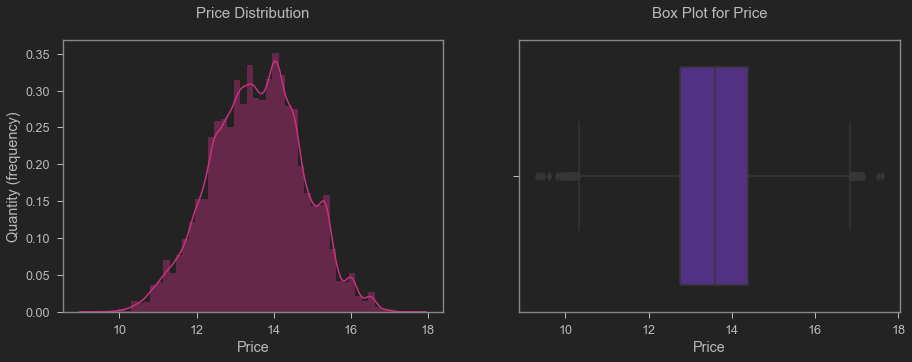

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(X_train.price.values, bins=50, color=colors[4])
plt.title('Price Distribution\n', fontsize=15)
plt.xlabel('Price')
plt.ylabel('Quantity (frequency)')

plt.subplot(122)
sns.boxplot(X_train.price.values, color=colors[1])
plt.title('Box Plot for Price\n', fontsize=15)
plt.xlabel('Price')

Looks better.
Let's again combine datasets for further engineering

In [21]:
# combine sets
df = X_train.append(X_test, sort=False).reset_index(drop=True)

<a id="sec6"></a>
## [body_type & Model_name](#sec6)
[(INDEX)](#sec2)

As we have quite a lot of brands in data set, and especially lot's of models,

let's generate new feature for each of mentioned model and brand by taking mean price of each model/brand

In [22]:
cols_to_process = ['model_name', 'brand', 'body_type']
for col in cols_to_process:
    col_mean_dict = df.groupby([col])['price'].mean().to_dict()
    df[f'priced_{col}'] = df[col].apply(lambda x: col_mean_dict[x])

We remember (EDA) that models number mismatch in train and test set.

So our new feature definately will have missing vars. Let's fix it by filling it with median

In [23]:
df['priced_model_name'].isna().sum()

17

In [24]:
df['priced_model_name'] = df['priced_model_name'].fillna(df['priced_model_name'].median())

Reduce quantity of body_types

In [25]:
pattern = re.compile('[а-я]*')
new_column = []
for string in df['body_type']:
    new_column.append(pattern.match(str(string))[0])
df['body_type'] = new_column

In [26]:
# Create list with top body types
top_colors = df['body_type'].value_counts()[df['body_type'].value_counts(
) > np.percentile((df['body_type'].value_counts().values), 70)].index.tolist()

#take all bodies from df to a list
all_colors = df['body_type'].value_counts().index

# Identify, what to delete
colors_to_drop = set(all_colors) - set(top_colors)

# Make replacemewnt
df.loc[df['body_type'].isin(colors_to_drop), 'body_type'] = 'other'

In [27]:
df['body_type'].value_counts()

седан          66649
внедорожник    63984
хэтчбек        16791
other          14990
лифтбек         9291
универсал       7030
Name: body_type, dtype: int64

Translate it to english. (for some reason, LightGBM doesn't work with russian column names)

In [28]:
body_type_dict = dict({
    'седан':'sedan',
    'внедорожник':'4wd',
    'хэтчбек':'hachtback',
    'other':'other',
    'лифтбек':'liftback',
    'универсал':'universal'
})
df['body_type'] = df['body_type'].map(body_type_dict)

In [29]:
df.body_type.unique()

array(['sedan', 'universal', 'other', '4wd', 'hachtback', 'liftback'],
      dtype=object)

Fine, we reduced number of body_types and translated it in to English

<a id="sec6"></a>
## [color](#sec6)
[(INDEX)](#sec2)

NOTE: After some experiments, it was decided to do not include this column in to a model. Bad impact on MAPE

With a reference to EDA section we generate new feature to show whether the color is popular.

Meanwhile we re-orgasnize colors in original column by taking only most common colors

In [ ]:
# # List of top3 colors (see EDA)
# # Has no impact
# popular_color = ['чёрный', 'белый', 'серый']
# df['popular_color'] = df['color'].apply(
#     lambda color: 1 if color in popular_color else 0)

In [ ]:
# # Create list with top colors
# # Has no impact
# top_colors = df['color'].value_counts()[df['color'].value_counts(
# ) > np.percentile((df['color'].value_counts().values), 80)].index.tolist()

# #take all colors from df to a list
# all_colors = df['color'].value_counts().index

# # Identify, what to delete
# colors_to_drop = set(all_colors) - set(top_colors)

# # Make replacemewnt
# df.loc[df['color'].isin(colors_to_drop), 'color'] = 'other'

In [ ]:
# df['color'].unique()

In [ ]:
# color_dict = dict({
#     #'синий':'blue',
#     'чёрный':'black',
#     'серый':'gray',
#     'other':'other',
#     'белый':'white',
#     #'серебристый':'silver'
# })
# df['color'] = df['color'].map(color_dict)

<a id="sec6"></a>
## [Model_name](#sec6)
[(INDEX)](#sec2)

NOTE: Already proceed above

<a id="sec6"></a>
## [Description](#sec6)
[(INDEX)](#sec2)

Let's generate new features:
- Sensitivity and polarity of each description in a column;
- Extract keywords from description

In [30]:
df['description'] = df['description'].fillna('none')
df['description'] = df['description'].apply(cleanTxt)
df['description'] = df['description'].apply(lambda x : x.lower())

In [31]:
# Create a function to get the subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


# Create a function to get the polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [32]:
# Create new cols and call the func

df['subjectivity'] = df['description'].apply(get_subjectivity)

df['polarity'] = df['description'].apply(get_polarity)

In [33]:
%%script false
# Note: useless insight. Do not include in the final set
# Create a function to compute the negative, neutral and positive analysis
def get_analysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

Couldn't find program: 'false'


In [34]:
%%script false
# Has no impact
df['analysis'] = df['polarity'].apply(get_analysis)

Couldn't find program: 'false'


With a reference to EDA (Sentiment section), let's check plot of worldcloud and generate new features. 

If description has specified keyword, the we add 1 to new column

In [35]:
df['airbags'] = df['description'].apply(
    lambda x: 1 if 'подушки безопасности' in x else 0)
df['cruise'] = df['description'].apply(
    lambda x: 1 if 'круиз' in x else 0)
df['steering'] = df['description'].apply(
    lambda x: 1 if 'усилитель руля' in x else 0)
df['loan'] = df['description'].apply(
    lambda x: 1 if 'кредит' in x else 0)
df['anti_block'] = df['description'].apply(
    lambda x: 1 if 'антиблокировочная' in x else 0)
df['lock'] = df['description'].apply(
    lambda x: 1 if 'центральный замок' in x else 0)
df['climat'] = df['description'].apply(
    lambda x: 1 if 'климат контроль' in x else 0)
df['rain_sens'] = df['description'].apply(
    lambda x: 1 if 'датчик дождя' in x else 0)

In [36]:
# show data
df.sample(4)

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,image,mileage,model_date,model_info,model_name,name,doors_count,price_currency,production_date,sell_id,super_gen,vehicle_configuration,vehicle_transmission,vendor,owner_count,owning_period,car_passport,wheel_drive,wheel_location,condition,custom,price,sample,priced_model_name,priced_brand,priced_body_type,subjectivity,polarity,airbags,cruise,steering,loan,anti_block,lock,climat,rain_sens
158420,4wd,nissan,серый,None,отличный авто. причина продажи- покупка нового,2.0,141.0,None,бензин,https://autoru.naydex.net/lxpu17803/f5b8d77s/u...,114000,2010,"{""code"":""qashqai"",""name"":""qashqai"",""ru_name"":""...",qashqai,2.0 cvt (141 л.с.) 4wd,5,rub,2010,1101262928,"{""id"":""6129638"",""displacement"":1997,""engine_ty...",allroad_5_doors variator 2.0,variator,japanese,3,None,original,полный,left,не требует ремонта,растаможен,NaN,0,14.037933,13.098955,14.356460,0.000000,0.00000,0,0,0,0,0,0,0,0
52011,sedan,toyota,белый,{'id': '0'},"автомобиль был куплен в январе этого года, тех...",2.0,135.0,"{'alloy-wheel-disks': true, 'tinted-glass': tr...",бензин,//avatars.mds.yandex.net/get-autoru-vos/473688...,337000,1992,"{'code': 'mark_ii', 'name': 'mark ii', 'ru_nam...",mark_ii,2.0 at (135 л.с.),4,rub,1993,1103245871,"{'id': '8304669', 'displacement': 1988, 'engin...",useless_col,automatic,japanese,3,"{'year': 2021, 'month': 1}",original,задний,right,None,None,13.017003,1,12.653909,13.470231,13.098326,0.000000,0.00000,0,0,0,0,0,0,0,0
1090,sedan,bmw,чёрный,{'id': '0'},мотор в хорошем состояние ходовая вхорошем сос...,2.0,150.0,"{'cruise-control': true, 'tinted-glass': true,...",бензин,//avatars.mds.yandex.net/get-autoru-vos/207920...,320000,1995,"{'code': '5er', 'name': '5 серии', 'ru_name': ...",5er,520i 2.0 mt (150 л.с.),4,rub,1999,1101545010,"{'id': '5139710', 'name': '520', 'nameplate': ...",useless_col,mechanical,european,2,None,duplicate,задний,left,None,None,12.506177,1,13.475687,14.254039,13.098326,0.000000,0.00000,0,0,0,0,0,0,0,0
88360,liftback,skoda,красный,"{'id': '22128725', 'name': 'style', 'available...",———————————————————————————функциональное обор...,1.6,110.0,"{'cruise-control': true, 'asr': true, 'tinted-...",бензин,//avatars.mds.yandex.net/get-autoru-vos/469755...,0,2020,"{'code': 'rapid', 'name': 'rapid', 'ru_name': ...",rapid,1.6 at (110 л.с.),5,rub,2021,1103633610,"{'id': '21738489', 'displacement': 1598, 'engi...",useless_col,automatic,european,NaN,None,original,передний,left,None,None,14.187764,1,13.813064,13.558353,13.636565,0.445238,0.04619,1,1,1,0,1,1,0,1


<a id="sec6"></a>
## [Equipment_dict](#sec6)
[(INDEX)](#sec2)

Let's exctrat the number of equipments listed in the subjected column

In [37]:
df['equipment_dict'].isna().sum()

9996

First of all, fill up missing values in the column

In [38]:
def fill_empty_equipment(model, dict_):
    if dict_=={}:
        return tipical_equipment_dict[model]
    return dict_

In [39]:
def fill_na_equip_lenght(model_name,value):
    if value==0:
        return int(mean_equip_lenhgt_dict[model_name])
    return value

In [40]:
df['equipment_dict'] = df['equipment_dict'].str.replace('\"', '\'').str.replace(
    ' ', '').str.replace(':t', ':T')  #  General view
df['equipment_dict'] = df['equipment_dict'].apply(lambda string: {} if pd.isna(
    string) else ast.literal_eval(string))  # transform string to dicts

In [41]:
# The idea is to create a dictionary: the most complete set of
# cars, then fill in the gaps with this dictionary
model_names = df['model_name'].unique()
tipical_equipment_dict = dict.fromkeys(model_names)
for model in model_names[:]:
    max_len = 0
    for dict_ in df[df['model_name'] ==
                    model]['equipment_dict'].value_counts().index:
        tipical_equipment_dict.update({model: dict_})
        if len(dict_) > max_len:
            tipical_equipment_dict.update({model: dict_})

In [42]:
df['equipment_dict'] = df[['model_name', 'equipment_dict']].apply(
    lambda x: fill_empty_equipment(*x), axis=1)

In [43]:
df['equipment_length'] = df['equipment_dict'].apply(lambda dict_: len(dict_))

mean_equip_lenhgt_dict = df.groupby('model_name')['equipment_length'].mean(
).round().to_dict()  # Словарь с среднимим значениями длин словарей экипировки

df['equipment_length'] = df[['model_name', 'equipment_length'
                             ]].apply(lambda x: fill_na_equip_lenght(*x),
                                      axis=1)  # filling

In [44]:
# Check if dictionaries contain False 
count_false=0
for dict_ in df['equipment_dict']:
    for i in dict_:
        if dict_[i]==False:
            count_false+=1
count_false

0

The length of the equipment_dict characterizes the number of functions in the auto 

In [ ]:
# df[df['equipment_dict']=={}]['model_name'].unique()

In [ ]:
# # Создадим множество всех атрибутов в авто
# attributes = set()
# for dict_ in df['equipment_dict']:    
#     attributes.update(dict_.keys())

In [ ]:
# dv = DictVectorizer()
# equipment_features = dv.fit_transform(
#     df.query('sample==1')['equipment_dict']).toarray()
# equipment_df = pd.DataFrame(equipment_features, columns=dv.get_feature_names())
# equipment_attributes = equipment_df.columns.values

In [ ]:
# f_scores, p_values = f_regression(equipment_df, df.query('sample==1')['price'])

In [ ]:
# # Visualizing 50 best equipment features
# plt.figure(figsize=(20, 10))
# f_scores = pd.Series(f_scores, equipment_attributes).sort_values(ascending=False)
# best_attributes = f_scores[:50].index
# f_scores[:50].plot(kind='barh', color='green')
# plt.xlabel('F-Score')
# plt.title('50 best equipment features', size=16);

In [ ]:
# 25% самых важных атрибутов в авто
# f_scores[f_scores.values > f_scores.values.max()*0.75]

In [ ]:
# most_important_attributes = set(f_scores[f_scores.values > f_scores.values.max(
# )*0.75].index)  # Множество самых важных атрибутов

In [ ]:
# def has_important_equipment(dict_):
#     # Проверка на принадлежность важнейших атрибутов атрибутам авто
#     if most_important_attributes.issubset(set(dict_.keys())):
#         return 1
#     return 0

In [ ]:
# df['has_important_attrs'] = df['equipment_dict'].apply(
#     lambda x: has_important_equipment(x))

In [ ]:
# df['has_important_attrs'].value_counts()

<a id="sec6"></a>
## [fuel_type](#sec6)
[(INDEX)](#sec2)

In [45]:
# lets strip fuel type
df['fuel_type'] = df.fuel_type.apply(lambda fuel: str(fuel).strip())

In [46]:
fuel_type_dict = dict({
    'бензин':'benzin',
    'дизель':'dizel',
    'гибрид':'hybrid',
    'электро':'electro',
    'газ':'gas'
})

df['fuel_type'] = df['fuel_type'].map(fuel_type_dict)

<a id="sec6"></a>
## [Mileage](#sec6)
[(INDEX)](#sec2)

With  a reference to EDA section (plot numerical distribution), outcomes, we remember, that some cars has milage = 0 which is incorrect or unlogical. Fix it here

Save information where mileage was equal to zero 

NOTE: Has no impact on MAPE

In [47]:
#df['mileage_zero'] = df['mileage'].apply(lambda x: 1 if x == 0 else 0)

<a id="sec6"></a>
## [engine_displacement](#sec6)
[(INDEX)](#sec2)

We know, that there is no engine displacement for the electical cars. We also know there is missing values in this colums.

Let's fix it. If car is electric - diplacement shall be 0.

In [48]:
df['engine_displacement'] = df[['engine_displacement','fuel_type']].apply(
    lambda x: get_electro_displacement(*x), axis=1)

It was observed that BMW model i3 has missing values in engine displacement. 

Let's say if it is a hybrid - then eng_displ - 0.7. If not - then 0

In [49]:
df['engine_displacement'] = df[[
    'engine_displacement', 'fuel_type', 'model_name'
]].apply(lambda x: get_i3_displacement(*x), axis=1)

<a id="sec6"></a>
## [engine_power](#sec6)
[(INDEX)](#sec2)

There is a special low in Russian Federation that devide cars by tax categories. 

More power in engine, higer grade of tax. It may impact on a prediction. Let's break our cars down by such categories

In [ ]:
# No impact on MAPE
# df['tax_rate'] = df['engine_power'].apply(
#     lambda engine_power: get_tax_category(engine_power)).astype('category')

In [50]:
# Fill up for 3 missing cars (civic)
df['engine_power'] = df['engine_power'].fillna(100) # CIVIC

In [51]:
# Break engine power by intervals
bins = [10, 35, 100, 125, 150, 175, 200, 225, 250, 801]
# Ctreate tax categories
numbers = ['5000', '12', '25', '35', '45', '50', '65', '75', '150']

In [52]:
# Make a column where refer each car depended by power to a tax cat
df['tax_base'] = pd.cut(df['engine_power'], bins, labels=numbers)
df['tax_base'] = df['tax_base'].values.astype('int64')

In [53]:
# generate tax fee col
df['tax'] = df['engine_power'] * df['tax_base']

<a id="sec6"></a>
## [Super_gen](#sec6)
[(INDEX)](#sec2)

Let's extract some information like an acceleration from supergen column.

Generate new feature Acceleration

In [54]:
# Before we do, fill up empty dictionaries with 'Nan'
df['super_gen'] = df['super_gen'].fillna('NaN')
df['super_gen'] = df['super_gen'].apply(cleanTxt)
# Extract fuel rate,acceleration and generate new feature
df['acceleration'] = df['super_gen'].apply(lambda string:get_acceleration(string))
df['fuel_rate'] = df['super_gen'].apply(lambda string:get_fuel_rate(string))

In [55]:
# missing vars in a new feature
df['acceleration'].isna().sum()

11243

In [56]:
df['fuel_rate'].isna().sum()

21408

Let's fill missing values by randomly choosen value from most common in particular colums.

For a company, add car pasport here and owner count

In [57]:
cols_to_fill = ['acceleration', 'fuel_rate', 'car_passport','owner_count']
for col in cols_to_fill:
    missing_vars(df,col)

<a id="sec6"></a>
## [Wheel drive](#sec6)
[(INDEX)](#sec2)

In [58]:
# lets strip fuel type
df['wheel_drive'] = df.wheel_drive.apply(lambda drive: str(drive).strip())

In [59]:
drive_type_dict = dict({
    'передний': 'front',
    'полный': 'full',
    'задний': 'rear',
})

df['wheel_drive'] = df['wheel_drive'].map(drive_type_dict)

In [60]:
df[df['wheel_drive'].isna()]

,body_type,brand,color,complectation_dict,description,engine_displacement,engine_power,equipment_dict,fuel_type,image,mileage,model_date,model_info,model_name,name,doors_count,price_currency,production_date,sell_id,super_gen,vehicle_configuration,vehicle_transmission,vendor,owner_count,owning_period,...,wheel_drive,wheel_location,condition,custom,price,sample,priced_model_name,priced_brand,priced_body_type,subjectivity,polarity,airbags,cruise,steering,loan,anti_block,lock,climat,rain_sens,equipment_length,mileage_zero,tax_base,tax,acceleration,fuel_rate
56730,other,toyota,серебристый,"{'id': '0', 'name': ''}",авто в хорошем тех. состоянии..гаражное хранен...,NaN,100.0,"{'abs': True, 'alarm': True, 'audiosystem-cd':...",NaN,//avatars.mds.yandex.net/get-autoru-vos/202337...,180000,1984,"{'code': 'noah', 'name': 'noah', 'ru_name': 'н...",noah,None,4,rub,2008,1092703248,nan,useless_col,None,japanese,3,None,...,NaN,right,None,None,13.444447,1,13.351231,13.470231,12.24931,0.0,0.0,0,0,0,0,0,0,0,0,4,0,12,1200.0,6.8,8.7
93719,other,honda,серебристый,"{'id': '0', 'name': ''}","продаю honda civic suttle 1989 г. выпуска, неу...",NaN,100.0,"{'electro-window-back': True, 'cruise-control'...",NaN,//avatars.mds.yandex.net/get-autoru-vos/216179...,400000,2012,"{'code': 'civic', 'name': 'civic', 'ru_name': ...",civic,None,5,rub,1989,1097454742,nan,useless_col,None,japanese,3,None,...,NaN,left,None,None,11.695247,1,12.708966,13.003090,12.24931,0.0,0.0,0,0,0,0,0,0,0,0,11,0,12,1200.0,6.8,7.0
94094,other,honda,пурпурный,"{'id': '0', 'name': ''}",в хорошем состоянии на ходу,NaN,100.0,"{'electro-window-back': True, 'cruise-control'...",NaN,//avatars.mds.yandex.net/get-autoru-vos/215360...,220000,2003,"{'code': 'civic', 'name': 'civic', 'ru_name': ...",civic,None,4,rub,1989,1096777604,nan,useless_col,None,japanese,3,None,...,NaN,left,None,None,11.608236,1,12.708966,13.003090,12.24931,0.0,0.0,0,0,0,0,0,0,0,0,11,0,12,1200.0,17.6,7.6


Civic. Fill With front

In [61]:
df['wheel_drive'] = df['wheel_drive'].fillna('front')

<a id="sec6"></a>
## [Price change index ](#sec6)
[(INDEX)](#sec2)

With a reference to EDA, we know, that some brands loose their price more faster than others. 

Let's generate such feature

In [63]:
def get_change_index(model):
    if model == 'ford':
        return int(1)
    if model == 'volvo' or model == 'mercedes':
        return int(2)
    if model == 'honda' or model == 'audi':
        return int(2)
    return int(0)

In [64]:
df['prc_chg_idx'] = df['brand'].apply(
    lambda brand: get_change_index(brand)).astype('category')

<a id="sec6"></a>
## [Dropping cars without info out](#sec6)
[(INDEX)](#sec2)

In [65]:
df['engine_displacement'].isna().sum()

3

In [66]:
df = df.dropna(axis=0, subset=['engine_displacement'])

<a id="sec6"></a>
## [Vendor](#sec6)
[(INDEX)](#sec2)

During scraping of a dataset we gathered more vendors than were in a test data set. Let's replace those who are not in test dataset by 'Other'

Note: It was decided to not include this to a model

In [67]:
df['vendor'] = df['vendor'].apply(
    lambda x: x if x == 'european' else(x if x == 'japanese' else 'other'))

<a id="sec6"></a>
## [Handling multicollinearity out](#sec6)
[(INDEX)](#sec2)

In [68]:
# extract trhee columns from dataset, which are correlated
data = df[['mileage', 'model_date', 'production_date']].values
# create Scaler instance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# We have 3 vectors. Reduce to two, taking most important info.
pca = PCA(n_components=2)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_1'], df['pca_2'] = pca_data[:, 0], pca_data[:, 1]

<a id="sec6"></a>
## [Clustering](#sec6)
[(INDEX)](#sec2)

In [ ]:
#cluster = Outliers_detector(df)

In [ ]:
# indeces = cluster.get_dbscan_outliers('model_date', 'mileage', dbscan_eps=.3,
#                                      dbscan_minsample=12,
#                                      cluster_num=-1)
# print(f"Strange guys {len(indeces)}")

In [ ]:
# Defining features and target
# X = df[df['sample'] == 1]

# X_test = df[df['sample'] == 0]

# print(f'X size: {X.shape}, X_testn size: {X_test.shape}')

In [ ]:
# cluster = Outliers_detector(X)

In [ ]:
# indeces = cluster.get_dbscan_outliers('model_date', 'price', dbscan_eps=.5,
#                                      dbscan_minsample=12,
#                                      cluster_num=-1)
# print(f"Strange guys {len(indeces)}")

In [ ]:
# X=X.drop(indeces)
# X.reset_index(drop=True, inplace=True)

In [ ]:
# df = X_test.append(X, sort=False).reset_index(drop=True)  # combine sets

<a id="sec6"></a>
## [Logarithm](#sec6)
[(INDEX)](#sec2)

In [70]:
cols_to_log = [
    'engine_displacement', 'mileage', 'model_date', 'production_date',
    'equipment_length', 'tax', 'acceleration', 'fuel_rate', 'pca_1', 'pca_2'
]

df = to_log(df, cols_to_log)

<a id="sec6"></a>
## [ENCODING](#sec6)
[(INDEX)](#sec2)

In [71]:
# Re-set indeces
df.reset_index(drop=True, inplace=True)

In [ ]:
# Save un-encoded df
df_cat = df.copy()

In [72]:
encoder = Encoder(df)

In [73]:
to_hot = [
    #'body_type', # No impact
    #'brand', # No impact
    #'color', # No impact
    #'fuel_type',   # No impact
    #'doors_count', # No impact
    #'vehicle_transmission', # No impact
    'vendor',
    'wheel_drive',
    'owner_count',
]

to_label = [
    'car_passport', 'wheel_location', 'prc_chg_idx', 'vehicle_transmission'
]

In [74]:
# hot it out
for col in to_hot:
    df = encoder.hot_encoder(col)

In [75]:
# label it
for col in to_label:
    encoder.label_encoder(col)

<a id="sec6"></a>
## [DROP COLS OUT](#sec6)
[(INDEX)](#sec2)

In [76]:
cols_to_drop = [
    'complectation_dict',
    'description',
    'equipment_dict',
    'image',
    'model_info',
    'name',
    'price_currency',
    'vehicle_configuration',
    'custom',
    'condition',
    'owning_period',
    'super_gen',
    'sell_id',
    'model_name',
    'engine_power',
    'mileage',  # have PCA instead
    'model_date',  # have PCA instead 
    'body_type',
    'brand',
    'color',
    'tax_base',
    'mileage_zero',  # No impact
    'fuel_type',  # No impact
    'doors_count'  # No impact
]
df = df.drop(cols_to_drop, axis=1)

Let's check what do we have now

engine_displacement - 0.0%
production_date - 0.0%
vehicle_transmission - 0.0%
car_passport - 0.0%
wheel_location - 0.0%
price - 19.407%
sample - 0.0%
priced_model_name - 0.0%
priced_brand - 0.0%
priced_body_type - 0.0%
subjectivity - 0.0%
polarity - 0.0%
airbags - 0.0%
cruise - 0.0%
steering - 0.0%
loan - 0.0%
anti_block - 0.0%
lock - 0.0%
climat - 0.0%
rain_sens - 0.0%
equipment_length - 0.0%
tax - 0.0%
acceleration - 0.0%
fuel_rate - 0.0%
prc_chg_idx - 0.0%
pca_1 - 0.0%
pca_2 - 0.0%
hot_vendor_european - 0.0%
hot_vendor_japanese - 0.0%
hot_vendor_other - 0.0%
hot_wheel_drive_front - 0.0%
hot_wheel_drive_full - 0.0%
hot_wheel_drive_rear - 0.0%
hot_owner_count_1 - 0.0%
hot_owner_count_2 - 0.0%
hot_owner_count_3 - 0.0%


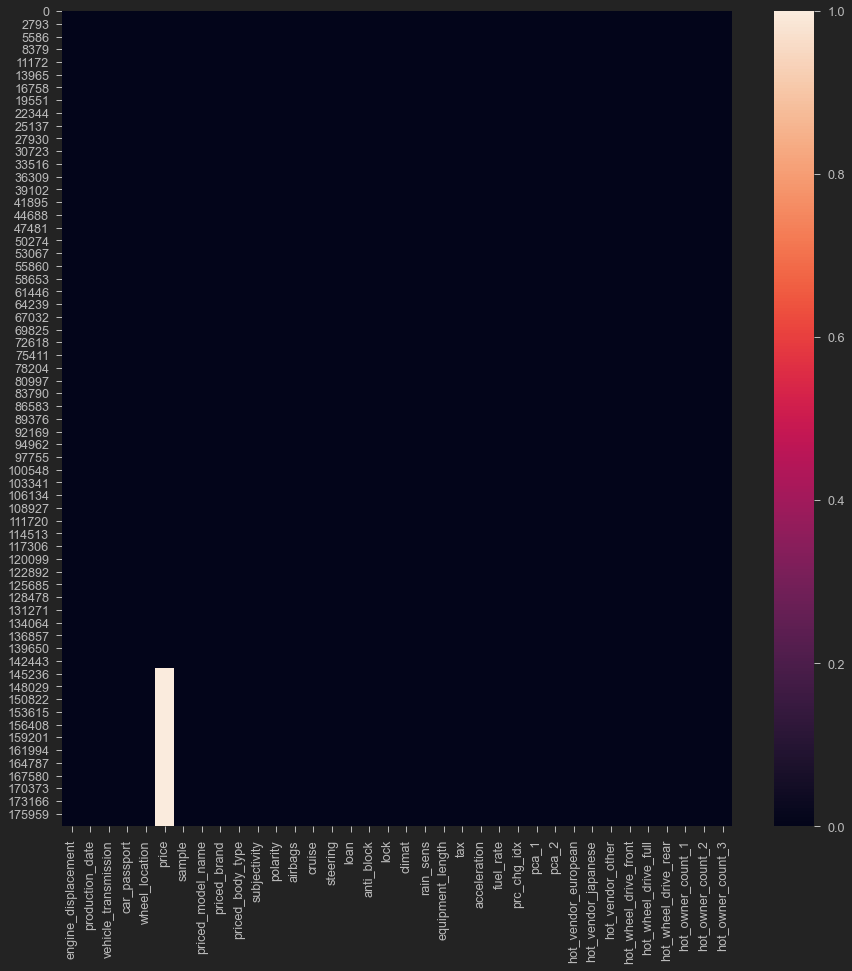

In [77]:
# Plot missing values
cols = df.columns
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df[cols].isnull()) 

# Show in percents
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(f'{col} - {round(pct_missing*100,3)}%')

The data set is ready.

<a id="sec6"></a>
# [Prepare Set For Model](#sec6)
[(INDEX)](#sec2)

In [79]:
# Defining features and target
X = df[df['sample'] == 1].drop(['price','sample'], axis=1)
y = df[df['sample'] == 1]['price']

X_test = df[df['sample'] == 0].drop(['price','sample'], axis=1)
y_test = df[df['sample'] == 0]['price']

In [80]:
cols_to_scal = [
    'engine_displacement', 'subjectivity', 
    'polarity', 'acceleration',
    'fuel_rate', 'pca_1','pca_2','equipment_length',
    'priced_model_name','priced_brand','priced_body_type','tax'
]

In [81]:
scaler = RobustScaler()
X[cols_to_scal] = scaler.fit_transform(X[cols_to_scal])
X_test[cols_to_scal] = scaler.transform(X_test[cols_to_scal])

In [82]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  random_state=42)

print(
    f'Train size: {X_train.shape}, Validation size: {X_val.shape}, Test size: {X_test.shape}'
)

Train size: (115236, 34), Validation size: (28810, 34), Test size: (34686, 34)


<a id="sec6"></a>
# [MODELS](#sec6)
[(INDEX)](#sec2)

In [ ]:
# reg = LazyRegressor(verbose=1, ignore_warnings=False, custom_metric=None)
# models,predictions = reg.fit(X_train, X_val, y_train, y_val)
# models

<a id="sec6"></a>
## [EXTRA-TREE](#sec6)
[(INDEX)](#sec2)

In [86]:
# Training and evaluating Extra Tree
rf = ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1,
                         bootstrap=True, verbose=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [87]:
df_report = pd.DataFrame(data=None)

In [88]:
df_report = get_regression_metrics(df_report,y_val,y_pred, 'ExtraTree_baseline')
df_report

,MAPE,MAE,MSE,RMSE
ExtraTree_baseline,15.282322,117142.087775,9.258594e+10,304279.377166


In [ ]:
# rf.fit(X, y) # Обучим для сабмита на всей выборке

In [89]:
sell_id = pd.read_csv('test.csv')['sell_id']

In [ ]:
# submission_tree = pd.DataFrame({'sell_id': sell_id,
#                            'price': np.exp(rf.predict(X_test))*0.905})

In [ ]:
# submission_tree.to_csv('submission_tree.csv', index=False)

<a id="sec6"></a>
## [CAT_boost](#sec6)
[(INDEX)](#sec2)

In [ ]:
# Training the model
cbr = CatBoostRegressor()

# Grid search for catboost model
param_grid = {'iterations': [500],
              'learning_rate': [0.01, 0.1, 0.25, 0.5],
              'l2_leaf_reg': [1, 3, 5, 10],
              'depth': np.arange(10, 14),
              'thread_count': [4]}

cbr.grid_search(param_grid=param_grid,
                X=X,
                y=y,
                cv=5,
                partition_random_seed=42,
                calc_cv_statistics=True,
                search_by_train_test_split=True,
                refit=True,
                shuffle=True,
                stratified=None,
                train_size=0.8,
                verbose=False,
                plot=True)

In [ ]:
cbr.fit(X_train,y_train)

In [114]:
cbr_pred = cbr.predict(X_val)

In [ ]:
# Best model parameters
cbr.get_params()

In [115]:
df_report = get_regression_metrics(df_report,y_val,cbr_pred, 'CatBoost')
df_report

,MAPE,MAE,MSE,RMSE
ExtraTree_baseline,15.282322,117142.087775,9.258594e+10,304279.377166
XGBoost_1,15.227861,118196.924462,9.005006e+10,300083.415508
XGBoost_opt,16.514804,147951.373157,1.178385e+11,343276.129743
LGB,15.757142,131982.177877,1.047078e+11,323585.842181
LGB+optuna,15.141508,124591.832130,1.179839e+11,343487.873636
CatBoost,15.591592,134115.271278,1.125135e+11,335430.298839


In [112]:
cbr = CatBoostRegressor(loss_function='RMSE',
                        thread_count=4,
                        depth=10,
                        l2_leaf_reg=1,
                        iterations=500,
                        learning_rate=0.1)

cbr.fit(X_train, y_train)

0:	learn: 1.0813048	total: 185ms	remaining: 1m 32s
1:	learn: 0.9884348	total: 227ms	remaining: 56.6s
2:	learn: 0.9043122	total: 269ms	remaining: 44.6s
3:	learn: 0.8300291	total: 313ms	remaining: 38.8s
4:	learn: 0.7637742	total: 355ms	remaining: 35.1s
5:	learn: 0.7052262	total: 397ms	remaining: 32.7s
6:	learn: 0.6519320	total: 440ms	remaining: 31s
7:	learn: 0.6047225	total: 483ms	remaining: 29.7s
8:	learn: 0.5631916	total: 525ms	remaining: 28.6s
9:	learn: 0.5267751	total: 570ms	remaining: 27.9s
10:	learn: 0.4943857	total: 610ms	remaining: 27.1s
11:	learn: 0.4659232	total: 653ms	remaining: 26.5s
12:	learn: 0.4409626	total: 694ms	remaining: 26s
13:	learn: 0.4189551	total: 737ms	remaining: 25.6s
14:	learn: 0.3998706	total: 777ms	remaining: 25.1s
15:	learn: 0.3834331	total: 834ms	remaining: 25.2s
16:	learn: 0.3688268	total: 875ms	remaining: 24.9s
17:	learn: 0.3565467	total: 916ms	remaining: 24.5s
18:	learn: 0.3458542	total: 962ms	remaining: 24.3s
19:	learn: 0.3367076	total: 1s	remaining: 24

164:	learn: 0.2276866	total: 7.05s	remaining: 14.3s
165:	learn: 0.2275350	total: 7.09s	remaining: 14.3s
166:	learn: 0.2273925	total: 7.13s	remaining: 14.2s
167:	learn: 0.2271930	total: 7.17s	remaining: 14.2s
168:	learn: 0.2269422	total: 7.21s	remaining: 14.1s
169:	learn: 0.2268648	total: 7.26s	remaining: 14.1s
170:	learn: 0.2267061	total: 7.3s	remaining: 14s
171:	learn: 0.2265626	total: 7.34s	remaining: 14s
172:	learn: 0.2262753	total: 7.38s	remaining: 14s
173:	learn: 0.2260275	total: 7.42s	remaining: 13.9s
174:	learn: 0.2258205	total: 7.47s	remaining: 13.9s
175:	learn: 0.2256141	total: 7.51s	remaining: 13.8s
176:	learn: 0.2254971	total: 7.55s	remaining: 13.8s
177:	learn: 0.2253126	total: 7.59s	remaining: 13.7s
178:	learn: 0.2250544	total: 7.64s	remaining: 13.7s
179:	learn: 0.2248026	total: 7.67s	remaining: 13.6s
180:	learn: 0.2246522	total: 7.72s	remaining: 13.6s
181:	learn: 0.2245576	total: 7.76s	remaining: 13.6s
182:	learn: 0.2244203	total: 7.8s	remaining: 13.5s
183:	learn: 0.224199

325:	learn: 0.2056330	total: 13.8s	remaining: 7.35s
326:	learn: 0.2055302	total: 13.8s	remaining: 7.3s
327:	learn: 0.2054892	total: 13.8s	remaining: 7.26s
328:	learn: 0.2053339	total: 13.9s	remaining: 7.22s
329:	learn: 0.2052426	total: 13.9s	remaining: 7.17s
330:	learn: 0.2051797	total: 14s	remaining: 7.13s
331:	learn: 0.2050294	total: 14s	remaining: 7.09s
332:	learn: 0.2049059	total: 14s	remaining: 7.04s
333:	learn: 0.2048014	total: 14.1s	remaining: 7s
334:	learn: 0.2046985	total: 14.1s	remaining: 6.96s
335:	learn: 0.2045829	total: 14.2s	remaining: 6.91s
336:	learn: 0.2045093	total: 14.2s	remaining: 6.87s
337:	learn: 0.2044360	total: 14.2s	remaining: 6.83s
338:	learn: 0.2043948	total: 14.3s	remaining: 6.79s
339:	learn: 0.2042693	total: 14.3s	remaining: 6.75s
340:	learn: 0.2042185	total: 14.4s	remaining: 6.71s
341:	learn: 0.2041416	total: 14.4s	remaining: 6.66s
342:	learn: 0.2040440	total: 14.5s	remaining: 6.62s
343:	learn: 0.2039757	total: 14.5s	remaining: 6.58s
344:	learn: 0.2038450	

485:	learn: 0.1913152	total: 20.3s	remaining: 586ms
486:	learn: 0.1912622	total: 20.4s	remaining: 544ms
487:	learn: 0.1911327	total: 20.4s	remaining: 502ms
488:	learn: 0.1910297	total: 20.5s	remaining: 460ms
489:	learn: 0.1909796	total: 20.5s	remaining: 418ms
490:	learn: 0.1909049	total: 20.5s	remaining: 376ms
491:	learn: 0.1908178	total: 20.6s	remaining: 335ms
492:	learn: 0.1907961	total: 20.6s	remaining: 293ms
493:	learn: 0.1907080	total: 20.7s	remaining: 251ms
494:	learn: 0.1906385	total: 20.7s	remaining: 209ms
495:	learn: 0.1906008	total: 20.7s	remaining: 167ms
496:	learn: 0.1905538	total: 20.8s	remaining: 125ms
497:	learn: 0.1904772	total: 20.8s	remaining: 83.6ms
498:	learn: 0.1904425	total: 20.9s	remaining: 41.8ms
499:	learn: 0.1904127	total: 20.9s	remaining: 0us


In [ ]:
submission_cat_boost = pd.DataFrame({
    'sell_id':
    sell_id,
    'price':
    np.exp(cbr.predict(X_test)) * 0.905
})

In [ ]:
submission_cat_boost.to_csv('submission_cat_boost.csv', index=False)

# XGBoost

In [90]:
# Training xgboost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000, silent=1)
xg_reg.fit(X_train, y_train)
xg_red_pred = xg_reg.predict(X_val)

[17:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [91]:
df_report = get_regression_metrics(df_report,y_val,xg_red_pred, 'XGBoost_1')
df_report

,MAPE,MAE,MSE,RMSE
ExtraTree_baseline,15.282322,117142.087775,9.258594e+10,304279.377166
XGBoost_1,15.227861,118196.924462,9.005006e+10,300083.415508


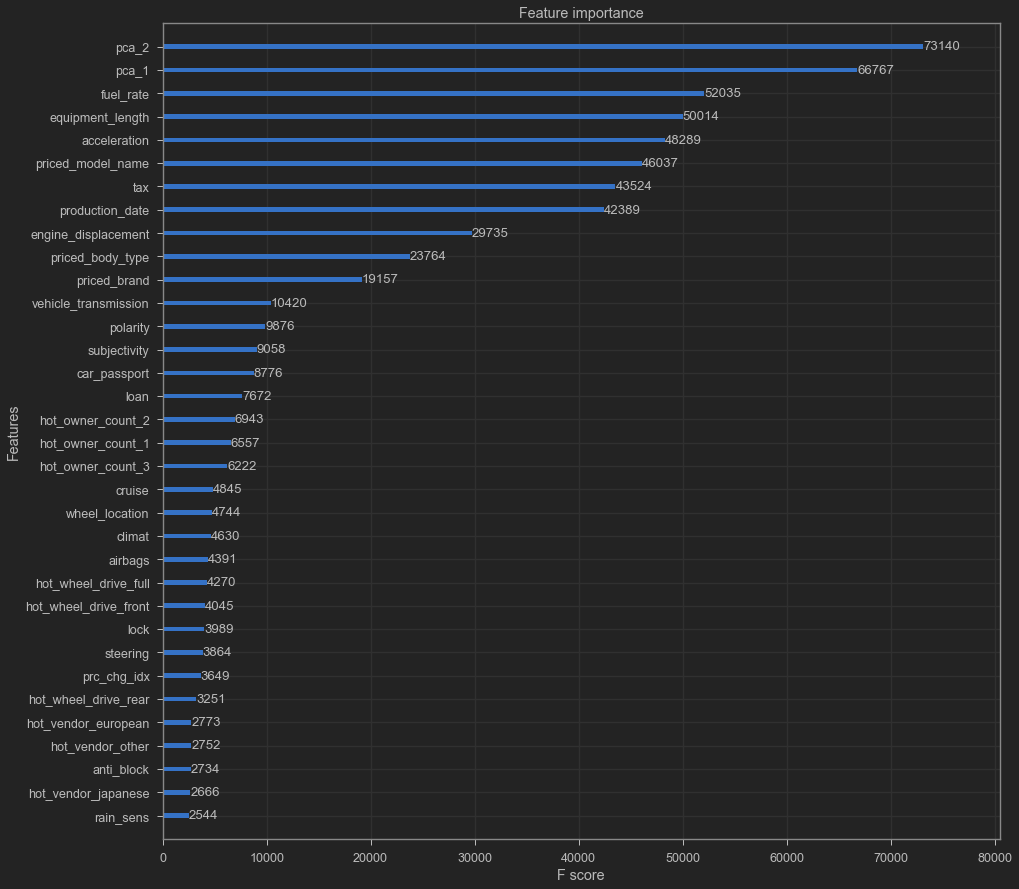

In [92]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
plot_importance(xg_reg,ax=ax);

In [ ]:
# submission_XGboost = pd.DataFrame({'sell_id': sell_id,
#                            'price': np.exp(xg_reg.predict(X_test))*0.905})

# submission_XGboost.to_csv('submission_XGboost.csv', index=False)

# LGBM

In [101]:
# Defining lightgbm hyper-parameters
hyper_params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': ['mape'],
                'learning_rate': 0.05,
                'feature_fraction': 0.9,
                'bagging_fraction': 0.7,
                'bagging_freq': 10,
                'verbose': 0,
                "max_depth": 12,
                "num_leaves": 128,  
                "max_bin": 512,
                "num_iterations": 1000,
                "n_estimators": 1000
            }

# Training lightgbm model
lgbm = lgb.LGBMRegressor(**hyper_params)
lgbm.fit(X_train, y_train,
         eval_set=[(X_val, y_val)],
         eval_metric='l1',
         early_stopping_rounds=100)

[1]	valid_0's l1: 0.906772	valid_0's mape: 0.067942
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l1: 0.863771	valid_0's mape: 0.0647327
[3]	valid_0's l1: 0.823213	valid_0's mape: 0.0617061
[4]	valid_0's l1: 0.784584	valid_0's mape: 0.0588227
[5]	valid_0's l1: 0.747833	valid_0's mape: 0.0560792
[6]	valid_0's l1: 0.713135	valid_0's mape: 0.0534895
[7]	valid_0's l1: 0.680279	valid_0's mape: 0.0510366
[8]	valid_0's l1: 0.649146	valid_0's mape: 0.0487128
[9]	valid_0's l1: 0.619689	valid_0's mape: 0.046514
[10]	valid_0's l1: 0.591875	valid_0's mape: 0.0444382
[11]	valid_0's l1: 0.565365	valid_0's mape: 0.0424596
[12]	valid_0's l1: 0.540402	valid_0's mape: 0.0405974
[13]	valid_0's l1: 0.516909	valid_0's mape: 0.0388442
[14]	valid_0's l1: 0.49461	valid_0's mape: 0.0371809
[15]	valid_0's l1: 0.473478	valid_0's mape: 0.0356038
[16]	valid_0's l1: 0.453621	valid_0's mape: 0.0341237
[17]	valid_0's l1: 0.434658	valid_0's mape: 0.0327087
[18]	valid_0's l1: 0.416896	vali

[154]	valid_0's l1: 0.150393	valid_0's mape: 0.0117044
[155]	valid_0's l1: 0.150387	valid_0's mape: 0.011704
[156]	valid_0's l1: 0.150311	valid_0's mape: 0.0116985
[157]	valid_0's l1: 0.150267	valid_0's mape: 0.0116951
[158]	valid_0's l1: 0.150258	valid_0's mape: 0.0116944
[159]	valid_0's l1: 0.150229	valid_0's mape: 0.0116923
[160]	valid_0's l1: 0.150179	valid_0's mape: 0.0116887
[161]	valid_0's l1: 0.150144	valid_0's mape: 0.0116864
[162]	valid_0's l1: 0.150057	valid_0's mape: 0.0116805
[163]	valid_0's l1: 0.150042	valid_0's mape: 0.0116793
[164]	valid_0's l1: 0.150048	valid_0's mape: 0.01168
[165]	valid_0's l1: 0.150004	valid_0's mape: 0.011677
[166]	valid_0's l1: 0.14992	valid_0's mape: 0.0116711
[167]	valid_0's l1: 0.149909	valid_0's mape: 0.0116703
[168]	valid_0's l1: 0.149912	valid_0's mape: 0.0116708
[169]	valid_0's l1: 0.1499	valid_0's mape: 0.0116703
[170]	valid_0's l1: 0.149888	valid_0's mape: 0.0116697
[171]	valid_0's l1: 0.14988	valid_0's mape: 0.011669
[172]	valid_0's l1:

[322]	valid_0's l1: 0.147478	valid_0's mape: 0.0115036
[323]	valid_0's l1: 0.147489	valid_0's mape: 0.0115045
[324]	valid_0's l1: 0.147513	valid_0's mape: 0.0115064
[325]	valid_0's l1: 0.147529	valid_0's mape: 0.0115078
[326]	valid_0's l1: 0.147537	valid_0's mape: 0.0115083
[327]	valid_0's l1: 0.147538	valid_0's mape: 0.0115084
[328]	valid_0's l1: 0.147494	valid_0's mape: 0.0115053
[329]	valid_0's l1: 0.147502	valid_0's mape: 0.0115059
[330]	valid_0's l1: 0.147474	valid_0's mape: 0.0115038
[331]	valid_0's l1: 0.147468	valid_0's mape: 0.0115034
[332]	valid_0's l1: 0.147468	valid_0's mape: 0.0115034
[333]	valid_0's l1: 0.147471	valid_0's mape: 0.0115036
[334]	valid_0's l1: 0.147472	valid_0's mape: 0.0115038
[335]	valid_0's l1: 0.147465	valid_0's mape: 0.0115032
[336]	valid_0's l1: 0.147472	valid_0's mape: 0.0115038
[337]	valid_0's l1: 0.147453	valid_0's mape: 0.0115024
[338]	valid_0's l1: 0.147429	valid_0's mape: 0.0115008
[339]	valid_0's l1: 0.147434	valid_0's mape: 0.0115013
[340]	vali

[490]	valid_0's l1: 0.146531	valid_0's mape: 0.0114435
[491]	valid_0's l1: 0.14653	valid_0's mape: 0.0114435
[492]	valid_0's l1: 0.146533	valid_0's mape: 0.0114438
[493]	valid_0's l1: 0.146526	valid_0's mape: 0.0114435
[494]	valid_0's l1: 0.146525	valid_0's mape: 0.0114435
[495]	valid_0's l1: 0.146545	valid_0's mape: 0.0114452
[496]	valid_0's l1: 0.14652	valid_0's mape: 0.0114434
[497]	valid_0's l1: 0.146463	valid_0's mape: 0.0114394
[498]	valid_0's l1: 0.14647	valid_0's mape: 0.01144
[499]	valid_0's l1: 0.14646	valid_0's mape: 0.0114393
[500]	valid_0's l1: 0.146462	valid_0's mape: 0.0114395
[501]	valid_0's l1: 0.146473	valid_0's mape: 0.0114404
[502]	valid_0's l1: 0.146475	valid_0's mape: 0.0114405
[503]	valid_0's l1: 0.146463	valid_0's mape: 0.0114397
[504]	valid_0's l1: 0.146456	valid_0's mape: 0.0114392
[505]	valid_0's l1: 0.14643	valid_0's mape: 0.0114373
[506]	valid_0's l1: 0.146414	valid_0's mape: 0.0114361
[507]	valid_0's l1: 0.146418	valid_0's mape: 0.0114364
[508]	valid_0's l

[669]	valid_0's l1: 0.146267	valid_0's mape: 0.0114337
[670]	valid_0's l1: 0.146267	valid_0's mape: 0.0114336
[671]	valid_0's l1: 0.146254	valid_0's mape: 0.0114328
[672]	valid_0's l1: 0.146256	valid_0's mape: 0.011433
[673]	valid_0's l1: 0.146252	valid_0's mape: 0.0114327
[674]	valid_0's l1: 0.146247	valid_0's mape: 0.0114323
[675]	valid_0's l1: 0.146256	valid_0's mape: 0.0114331
[676]	valid_0's l1: 0.146243	valid_0's mape: 0.0114322
[677]	valid_0's l1: 0.146224	valid_0's mape: 0.0114306
[678]	valid_0's l1: 0.146222	valid_0's mape: 0.0114304
[679]	valid_0's l1: 0.146205	valid_0's mape: 0.0114294
[680]	valid_0's l1: 0.146216	valid_0's mape: 0.0114303
[681]	valid_0's l1: 0.146211	valid_0's mape: 0.0114297
[682]	valid_0's l1: 0.14621	valid_0's mape: 0.0114297
[683]	valid_0's l1: 0.146211	valid_0's mape: 0.0114297
[684]	valid_0's l1: 0.146195	valid_0's mape: 0.0114284
[685]	valid_0's l1: 0.146189	valid_0's mape: 0.0114278
[686]	valid_0's l1: 0.146188	valid_0's mape: 0.0114278
[687]	valid_

[820]	valid_0's l1: 0.146027	valid_0's mape: 0.0114205
[821]	valid_0's l1: 0.146033	valid_0's mape: 0.011421
[822]	valid_0's l1: 0.146034	valid_0's mape: 0.011421
[823]	valid_0's l1: 0.146041	valid_0's mape: 0.0114216
[824]	valid_0's l1: 0.146047	valid_0's mape: 0.0114221
[825]	valid_0's l1: 0.146058	valid_0's mape: 0.0114231
[826]	valid_0's l1: 0.146064	valid_0's mape: 0.0114236
[827]	valid_0's l1: 0.14607	valid_0's mape: 0.0114241
[828]	valid_0's l1: 0.146078	valid_0's mape: 0.0114248
[829]	valid_0's l1: 0.146089	valid_0's mape: 0.0114257
[830]	valid_0's l1: 0.146094	valid_0's mape: 0.0114261
[831]	valid_0's l1: 0.146088	valid_0's mape: 0.0114256
[832]	valid_0's l1: 0.14608	valid_0's mape: 0.011425
[833]	valid_0's l1: 0.146085	valid_0's mape: 0.0114254
[834]	valid_0's l1: 0.146088	valid_0's mape: 0.0114257
[835]	valid_0's l1: 0.146082	valid_0's mape: 0.0114253
[836]	valid_0's l1: 0.146072	valid_0's mape: 0.0114245
[837]	valid_0's l1: 0.146072	valid_0's mape: 0.0114244
[838]	valid_0's

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.05, max_bin=512, max_depth=12, metric=['mape'],
              n_estimators=1000, num_iterations=1000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [102]:
lgb_pred = lgbm.predict(X_val)

In [103]:
df_report = get_regression_metrics(df_report,y_val,lgb_pred, 'LGB')
df_report

,MAPE,MAE,MSE,RMSE
ExtraTree_baseline,15.282322,117142.087775,9.258594e+10,304279.377166
XGBoost_1,15.227861,118196.924462,9.005006e+10,300083.415508
XGBoost_opt,16.514804,147951.373157,1.178385e+11,343276.129743
LGB,15.757142,131982.177877,1.047078e+11,323585.842181


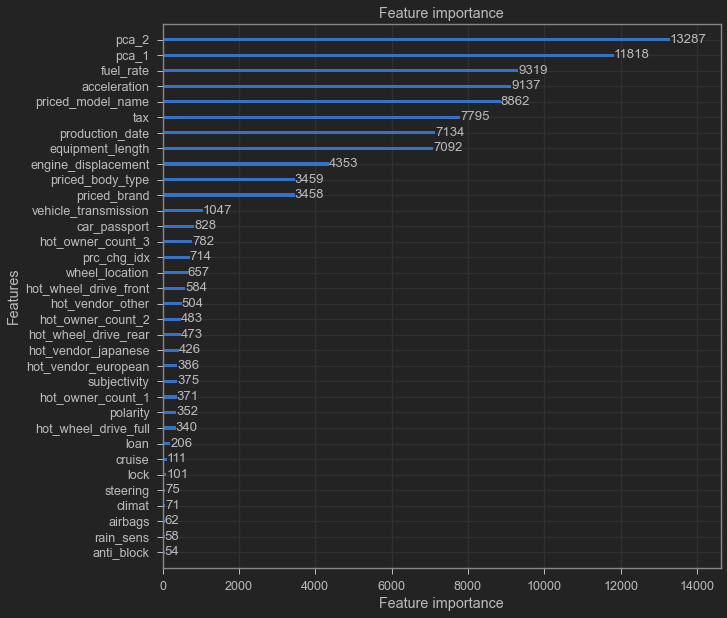

In [104]:
# Check permutation
lightgbm.plot_importance(lgbm, ax=None, height=0.2, xlim=None, ylim=None,
                         title='Feature importance', xlabel='Feature importance', 
                         ylabel='Features', importance_type='split', max_num_features=None,
                         ignore_zero=True, figsize=(10,10), dpi=None, grid=True, precision=3);

# LGBM Optuna

In [105]:
# Defining MAPE function since it was removed from sklearn
def mape_11(y_pred,y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [106]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'mape', 
        'random_state': 42,
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100,500,700]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = lgb.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    mape = mape_11(np.expm1(test_y), np.expm1(preds))
    
    return mape

In [107]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2021-05-30 18:28:54,085] A new study created in memory with name: no-name-7ac1d558-79a7-44d9-8d2a-56a59ce81972
[I 2021-05-30 18:29:00,535] Trial 0 finished with value: 15.344642993036146 and parameters: {'n_estimators': 500, 'reg_alpha': 0.001788283309040378, 'reg_lambda': 0.013546086674783327, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 977, 'min_child_samples': 189, 'min_data_per_groups': 57}. Best is trial 0 with value: 15.344642993036146.
[I 2021-05-30 18:29:05,298] Trial 1 finished with value: 15.738346166282739 and parameters: {'n_estimators': 700, 'reg_alpha': 0.21981320832444287, 'reg_lambda': 0.02615624057804746, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 207, 'min_child_samples': 246, 'min_data_per_groups': 61}. Best is trial 0 with value: 15.344642993036146.
[I 2021-05-30 18:29:19,519] Trial 2 finished with value: 15.05873187358379 and parameters: {'n_estimators': 7

[I 2021-05-30 18:31:51,794] Trial 21 finished with value: 15.082075424362001 and parameters: {'n_estimators': 500, 'reg_alpha': 0.1889627841879038, 'reg_lambda': 0.16410106603498373, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 972, 'min_child_samples': 30, 'min_data_per_groups': 66}. Best is trial 20 with value: 15.030563319731202.
[I 2021-05-30 18:32:04,426] Trial 22 finished with value: 15.039572072934675 and parameters: {'n_estimators': 500, 'reg_alpha': 0.11182499898003706, 'reg_lambda': 0.05380610205778333, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 786, 'min_child_samples': 35, 'min_data_per_groups': 69}. Best is trial 20 with value: 15.030563319731202.
[I 2021-05-30 18:32:17,414] Trial 23 finished with value: 15.013493378953546 and parameters: {'n_estimators': 500, 'reg_alpha': 0.7392166518857533, 'reg_lambda': 0.3164862768202664, 'colsample_bytree': 0.8, 'subsample': 0.5

[I 2021-05-30 18:35:17,070] Trial 42 finished with value: 14.911286501255802 and parameters: {'n_estimators': 500, 'reg_alpha': 0.9189135311238178, 'reg_lambda': 6.62847941103371, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 999, 'min_child_samples': 80, 'min_data_per_groups': 40}. Best is trial 42 with value: 14.911286501255802.
[I 2021-05-30 18:35:26,024] Trial 43 finished with value: 15.01115120120384 and parameters: {'n_estimators': 500, 'reg_alpha': 0.2788632443782095, 'reg_lambda': 9.771021268165224, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 965, 'min_child_samples': 158, 'min_data_per_groups': 28}. Best is trial 42 with value: 14.911286501255802.
[I 2021-05-30 18:35:28,260] Trial 44 finished with value: 16.992470036573447 and parameters: {'n_estimators': 500, 'reg_alpha': 3.8753002460634196, 'reg_lambda': 5.870011630698922, 'colsample_bytree': 0.6, 'subsample': 0.8, 'lear

In [ ]:
# plot_optimization_histor: shows the scores from all trials as 
# well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [ ]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [ ]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [ ]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [108]:
param_lgb = study.best_params

In [109]:
lgb_opt = lgb.LGBMRegressor(**param_lgb)
lgb_opt.fit(X_train, y_train,)
#          eval_set=[(X_val, y_val)],
#          eval_metric='l1',
#          early_stopping_rounds=100)


LGBMRegressor(colsample_bytree=0.6, learning_rate=0.02, max_depth=100,
              min_child_samples=80, min_data_per_groups=40, n_estimators=500,
              num_leaves=999, reg_alpha=0.9189135311238178,
              reg_lambda=6.62847941103371, subsample=0.5)

In [110]:
lgb_opt_pred = lgb_opt.predict(X_val)

In [111]:
df_report = get_regression_metrics(df_report,y_val,lgb_opt_pred, 'LGB+optuna')
df_report

,MAPE,MAE,MSE,RMSE
ExtraTree_baseline,15.282322,117142.087775,9.258594e+10,304279.377166
XGBoost_1,15.227861,118196.924462,9.005006e+10,300083.415508
XGBoost_opt,16.514804,147951.373157,1.178385e+11,343276.129743
LGB,15.757142,131982.177877,1.047078e+11,323585.842181
LGB+optuna,15.141508,124591.832130,1.179839e+11,343487.873636


## Gradient boost

In [ ]:
params = {'n_estimators': 800,
          'max_depth': 8,
          'min_samples_split': 7,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [ ]:
gboost = GradientBoostingRegressor(**params)
gboost.fit(X_train, y_train)
gboost_pred = gboost.predict(X_val)

In [ ]:
df_report = get_regression_metrics(df_report,y_val,gboost_pred, 'GBOOST')
df_report

In [ ]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, gboost_pred in enumerate(gboost.staged_predict(X_val)):
    test_score[i] = gboost.loss_(y_val, gboost_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gboost.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [ ]:
gboost.fit(X_train, y_train)

In [ ]:
submission_gboost = pd.DataFrame({'sell_id': sell_id,
                           'price': np.exp(gboost.predict(X_test))*0.905})

submission_gboost.to_csv('submission_gboost.csv', index=False)

## STACKING

In [ ]:
from mlxtend.regressor import StackingRegressor

In [ ]:
ENet = ElasticNet()

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
stck_regrs = StackingRegressor(regressors=[rf,cbr,xg_reg,lgbm,gboost],
                               meta_regressor=lr)

In [ ]:
stck_regrs.fit(X_train,y_train)

In [ ]:
y_pred_stck_regrs = stck_regrs.predict(X_val)

In [ ]:
df_report = get_regression_metrics(df_report,y_val,y_pred_stck_regrs, 'Stack')
df_report

In [118]:
extra_pred = rf.predict(X_test)
cbr_pred = cbr.predict(X_test)
xgboost_pred = xg_reg.predict(X_test)
lgb_opt_pred = lgb_opt.predict(X_test)
# lgb_pred = lgbm.predict(X_test)
# gboost = gboost.predict(X_test)
# stck = stck_regrs.predict(X_test)

In [116]:
df_report

,MAPE,MAE,MSE,RMSE
ExtraTree_baseline,15.282322,117142.087775,9.258594e+10,304279.377166
XGBoost_1,15.227861,118196.924462,9.005006e+10,300083.415508
XGBoost_opt,16.514804,147951.373157,1.178385e+11,343276.129743
LGB,15.757142,131982.177877,1.047078e+11,323585.842181
LGB+optuna,15.141508,124591.832130,1.179839e+11,343487.873636
CatBoost,15.591592,134115.271278,1.125135e+11,335430.298839


In [119]:
ensemble = (xgboost_pred*.1 + extra_pred*.1 + cbr_pred*.1 + lgb_opt_pred* .7)

In [ ]:
# #Submission
# stck_regrs = StackingRegressor(regressors=[lgbm, xg_reg, rf,cbr],
#                                meta_regressor=lr)
# stck_regrs.fit(X,y)

In [120]:
submission_stack = pd.DataFrame({'sell_id': sell_id,
                           'price': np.exp(ensemble)*.92})

submission_stack.to_csv('submission_stack.csv', index=False)